# Results of simulation of different makespan policies

These experiments use accumulated deficits to try to ensure that applications always receive their computed allocation of GPU time, even in the event of new jobs coming in and old jobs finishing, by keeping track of the difference between the GPU time the application should have received, and the GPU time the application actually received. Allocation of jobs to GPUs is performed in a round-based fashion, with GPUs instructed to run jobs for a fixed interval of time on all GPUs.

# Import statements

In [1]:
# Imports for plotting.
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
rc('text',
   usetex=True)
sns.set_style('ticks')
font = {
    'font.family':'Times New Roman',
    'font.weight': 200,
    'font.size': 10,
}
sns.set_style(font)
flatui = ['#002A5E', '#FD151B', '#8EBA42', '#348ABD', '#988ED5', '#BDB76B', '#8EBA42', '#FFB5B8']
sns.set_palette(flatui)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.bf': 'Times New Roman:bold',
}
sns.set_context("paper", font_scale=2,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
# Other imports.
import os
import re

# Get logfile paths

In [3]:
def get_logfile_paths_helper(directory_name):
    logfile_paths = []
    for root, _, file_names in os.walk(directory_name):
        if len(file_names) > 0:
            logfile_paths.extend(
                [os.path.join(root, file_name)
                 for file_name in file_names])
    return logfile_paths

def get_logfile_paths(directory_name):
    logfile_paths = []
    for logfile_path in get_logfile_paths_helper(directory_name):
        m = re.match(
            r'.*v100=(\d+)\.p100=(\d+)\.k80=(\d+)/(.*)/seed=(\d+)/'
             'num_total_jobs=(\d+)\.log', logfile_path)
        if m is None: continue
        v100s = int(m.group(1))
        p100s = int(m.group(2))
        k80s = int(m.group(3))
        policy = m.group(4)
        seed = int(m.group(5))
        num_total_jobs = int(m.group(6))
        logfile_paths.append((v100s, p100s, k80s, policy, seed,
                              num_total_jobs, logfile_path))
    return logfile_paths

In [4]:
labels = {"fifo": "FIFO",
          "fifo_perf": "FIFO+perf",
          "fifo_packed": "FIFO+perf+packed",
          "max_min_fairness": "MMF",
          "max_min_fairness_perf": "MMF+perf",
          "max_min_fairness_packed": "MMF+perf+packed",
          "min_total_duration": "Makespan+perf",
          "min_total_duration_packed": "Makespan+perf+packed"}

# Plotting functions

In [5]:
def prune(logfile_paths, v100s, p100s, k80s, policy, seed=None):
    if seed is None:
        return sorted([(x[5], x[6], x[4]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and x[5] <= 500])
    else:
        return sorted([(x[5], x[6]) for x in logfile_paths
                       if x[0] == v100s and x[1] == p100s and
                       x[2] == k80s and x[3] == policy and
                       x[4] == seed and x[5] <= 500])

In [6]:
def plot_metric_vs_num_total_jobs(logfile_paths,
                                  v100s, p100s, k80s, policies, metric_fn,
                                  metric_label, xmax=None, ymax=None,
                                  output_filename=None):
    plt.figure(figsize=(8, 3.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

    data = {"num_total_jobs": [], "metric": [], "seed": [],
            "policy": []}
    for policy in policies:
        relevant_logfile_paths = list(reversed(prune(
            logfile_paths, v100s, p100s, k80s, policy)))
        num_total_jobs = [x[0] for x in relevant_logfile_paths]
        metrics = [metric_fn(x[1]) for x in relevant_logfile_paths]
        seeds = [x[2] for x in relevant_logfile_paths]
        policies = [labels[policy] for i in range(len(metrics))]

        import pandas as pd
        data["num_total_jobs"] += num_total_jobs
        data["metric"] += metrics
        data["seed"] += seeds
        data["policy"] += policies

    sns.lineplot(x='num_total_jobs', y='metric', style='policy',
                 hue='policy',
                 data=data, ci='sd',
                 markers=True)

    ax.set_xlabel("Number of jobs")
    ax.set_ylabel(metric_label)
    ax.set_xlim([70, xmax])
    ax.set_ylim([0, ymax])
    sns.despine()
    
    plt.legend()
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    plt.show()

In [7]:
def makespan_fn(logfile_path):
    job_completion_times = []
    with open(logfile_path, 'r') as f:
        lines = f.readlines()
        for line in lines[-10000:]:
            m = re.match(r'Total duration: (\d+\.\d+) seconds', line)
            if m is not None:
                makespan = float(m.group(1)) / 3600.
                return makespan
    return None

# Plot makespan versus input job rate for single-GPU traces

In [8]:
logfile_paths = sorted(
    get_logfile_paths(
        "/lfs/1/deepak/gpusched/scheduler/logs/single_gpu_trace_min_total_duration_final/"))

V100s=64, P100s=0, K80s=0


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


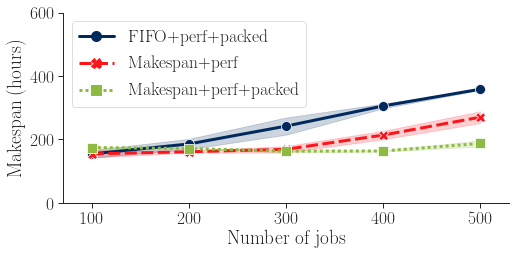

In [9]:
print("V100s=64, P100s=0, K80s=0")
plot_metric_vs_num_total_jobs(
    logfile_paths,
    v100s=64, p100s=0, k80s=0,
    policies=["fifo_packed", "min_total_duration", "min_total_duration_packed"],
    metric_fn=makespan_fn,
    metric_label="Makespan (hours)",
    xmax=530,
    ymax=600,
    output_filename="makespan/single_gpu_v100=64_p100=0_k80=0.pdf"
)

V100s=48, P100s=32, K80s=16


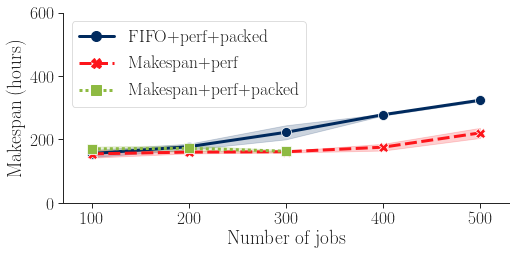

In [10]:
print("V100s=48, P100s=32, K80s=16")
plot_metric_vs_num_total_jobs(
    logfile_paths,
    v100s=48, p100s=32, k80s=16,
    policies=["fifo_packed", "min_total_duration", "min_total_duration_packed"],
    metric_fn=makespan_fn,
    metric_label="Makespan (hours)",
    xmax=530,
    ymax=600,
    output_filename="makespan/single_gpu_v100=48_p100=32_k80=16.pdf"
)

V100s=36, P100s=36, K80s=36


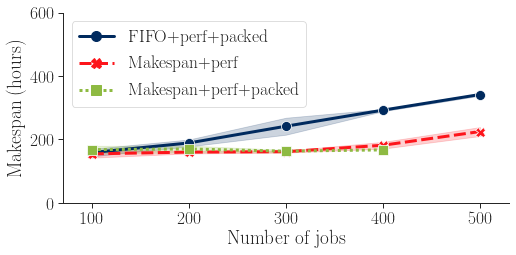

In [11]:
print("V100s=36, P100s=36, K80s=36")
plot_metric_vs_num_total_jobs(
    logfile_paths,
    v100s=36, p100s=36, k80s=36,
    policies=["fifo_packed", "min_total_duration", "min_total_duration_packed"],
    metric_fn=makespan_fn,
    metric_label="Makespan (hours)",
    xmax=530,
    ymax=600,
    output_filename="makespan/single_gpu_v100=36_p100=36_k80=36.pdf"
)

# Plot makespan versus input job rate for multi-GPU traces

In [12]:
multi_gpu_logfile_paths = sorted(
    get_logfile_paths(
        "/lfs/1/deepak/gpusched/scheduler/logs/multi_gpu_trace_min_total_duration_final/"))

V100s=64, P100s=0, K80s=0


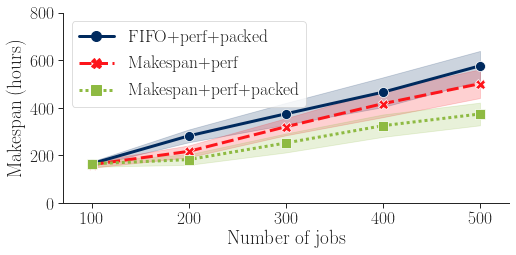

In [13]:
print("V100s=64, P100s=0, K80s=0")
plot_metric_vs_num_total_jobs(
    multi_gpu_logfile_paths,
    v100s=64, p100s=0, k80s=0,
    policies=["fifo_packed", "min_total_duration", "min_total_duration_packed"],
    metric_fn=makespan_fn,
    metric_label="Makespan (hours)",
    xmax=530,
    ymax=800,
    output_filename="makespan/multi_gpu_v100=64_p100=0_k80=0.pdf"
)

V100s=48, P100s=32, K80s=16


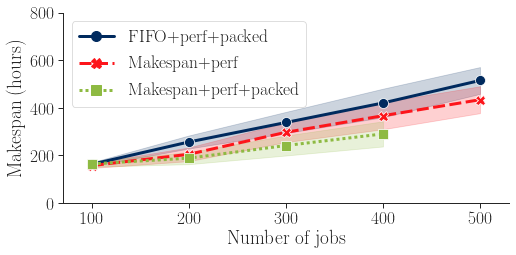

In [14]:
print("V100s=48, P100s=32, K80s=16")
plot_metric_vs_num_total_jobs(
    multi_gpu_logfile_paths,
    v100s=48, p100s=32, k80s=16,
    policies=["fifo_packed", "min_total_duration", "min_total_duration_packed"],
    metric_fn=makespan_fn,
    metric_label="Makespan (hours)",
    xmax=530,
    ymax=800,
    output_filename="makespan/multi_gpu_v100=48_p100=32_k80=16.pdf"
)

V100s=36, P100s=36, K80s=36


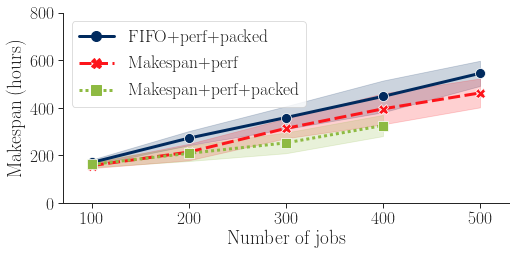

In [15]:
print("V100s=36, P100s=36, K80s=36")
plot_metric_vs_num_total_jobs(
    multi_gpu_logfile_paths,
    v100s=36, p100s=36, k80s=36,
    policies=["fifo_packed", "min_total_duration", "min_total_duration_packed"],
    metric_fn=makespan_fn,
    metric_label="Makespan (hours)",
    xmax=530,
    ymax=800,
    output_filename="makespan/multi_gpu_v100=36_p100=36_k80=36.pdf"
)